In [19]:
# 0) Neophodni importi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro

In [20]:
# 1) Učitavanje
data = pd.read_csv('fastfood.csv', na_values=['NA'])
display(data.head())
print(data.info())
data.isna().sum()
# Možemo primetiti da su se atributi restaurant, item, cal_fat, protein učitali kao "object".
# Item i restaurant možemo i ostaviti u ovom obliku, jer su po prirodi nenumeričke
# Takođe, samo atributi fiber, protein i calcium poseduju NA vrednosti

,restaurant,item,calories,cal_fat,total_fat,sat_fat,trans_fat,cholesterol,sodium,total_carb,fiber,sugar,protein,calcium
0,Mcdonalds,Artisan Grilled Chicken Sandwich,380,60,7,2.0,0.0,95,1110,44,3.0,11,37,20.0
1,Mcdonalds,Single Bacon Smokehouse Burger,840,410,45,17.0,1.5,130,1580,62,2.0,18,46,20.0
2,Mcdonalds,Double Bacon Smokehouse Burger,1130,600,67,27.0,3.0,220,1920,63,3.0,18,70,50.0
3,Mcdonalds,Grilled Bacon Smokehouse Chicken Sandwich,750,280,31,10.0,0.5,155,1940,62,2.0,18,55,20.0
4,Mcdonalds,Crispy Bacon Smokehouse Chicken Sandwich,920,410,45,12.0,0.5,120,1980,81,4.0,18,46,20.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   restaurant   515 non-null    object 
 1   item         515 non-null    object 
 2   calories     515 non-null    int64  
 3   cal_fat      515 non-null    object 
 4   total_fat    515 non-null    int64  
 5   sat_fat      515 non-null    float64
 6   trans_fat    515 non-null    float64
 7   cholesterol  515 non-null    int64  
 8   sodium       515 non-null    int64  
 9   total_carb   515 non-null    int64  
 10  fiber        503 non-null    float64
 11  sugar        515 non-null    int64  
 12  protein      514 non-null    object 
 13  calcium      305 non-null    float64
dtypes: float64(4), int64(6), object(4)
memory usage: 56.5+ KB
None


restaurant       0
item             0
calories         0
cal_fat          0
total_fat        0
sat_fat          0
trans_fat        0
cholesterol      0
sodium           0
total_carb       0
fiber           12
sugar            0
protein          1
calcium        210
dtype: int64

In [21]:
# 2) Podskup sa vrednoscu total_fat ≤ 125
data_subset = data.loc[data['total_fat'] <= 125].copy()
print(f"Broj redova u data_subset: {len(data_subset)}")
print(f"Broj redova u originalnom datesetu: {len(data)}")

Broj redova u data_subset: 513
Broj redova u originalnom datesetu: 515


In [22]:
# 3) Obrada nedostajucih vrednosti
special_missing = ['-', ' ', '']
# Proverimo koje kolone poseduje specijalne karaktere
print(data_subset.isin(['-', ' ', '']).sum())
# Zamenimo specijalne karaktere
data_subset.replace(special_missing, np.nan, inplace=True)
# Ponovna provera
print(data_subset.isin(['-', ' ', '']).sum())
# Pretvaramo cal_fat i protein u numeričke (jer su trenutno object)
data_subset['protein'] = pd.to_numeric(data_subset['protein'], errors='coerce')
data_subset['cal_fat'] = pd.to_numeric(data_subset['cal_fat'], errors='coerce')
# Pravimo subset, samo numerički podaci
data_numeric = data_subset.select_dtypes(include=['number']).copy()
print(data_numeric.columns)
print(data_numeric.info())

restaurant     3
item           0
calories       0
cal_fat        1
total_fat      0
sat_fat        0
trans_fat      0
cholesterol    0
sodium         0
total_carb     0
fiber          0
sugar          0
protein        1
calcium        0
dtype: int64
restaurant     0
item           0
calories       0
cal_fat        0
total_fat      0
sat_fat        0
trans_fat      0
cholesterol    0
sodium         0
total_carb     0
fiber          0
sugar          0
protein        0
calcium        0
dtype: int64
Index(['calories', 'cal_fat', 'total_fat', 'sat_fat', 'trans_fat',
       'cholesterol', 'sodium', 'total_carb', 'fiber', 'sugar', 'protein',
       'calcium'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 513 entries, 0 to 514
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   calories     513 non-null    int64  
 1   cal_fat      512 non-null    float64
 2   total_fat    513 non-null    int64  
 3   

In [23]:
# Provera NA -> cal_fat, fiber, protein i calcium imaju NA vrednosti. Potrebno je zameniti ih
data_numeric.isna().sum()
# Provera NA u procentima -> vidimo da calcium ima čak 41% NA vrednosti
print((data_numeric.isna().mean() * 100).round(2))
#Atribut calcium ima dosta nedostajućih vrednosti, pa neće biti ni zamenjene.
#Atribut calcium se izbacuje iz dataseta, zbog prevelikog broja nedostajućih vrednosti.
#(Za granicu se može uzeti >20%)
data_numeric.drop(columns='calcium', inplace=True)

calories        0.00
cal_fat         0.19
total_fat       0.00
sat_fat         0.00
trans_fat       0.00
cholesterol     0.00
sodium          0.00
total_carb      0.00
fiber           2.34
sugar           0.00
protein         0.39
calcium        40.74
dtype: float64


In [24]:
# Atributi sa NA (ali koji nisu izbačeni kao calcium)
cols_with_na = ['cal_fat', 'fiber', 'protein']
# Provera normalne raspodele
for col in cols_with_na:
    series = data_numeric[col].dropna()
    stat, p = shapiro(series)
    print(f"{col}: p = {p:.5f} → {'nije normalna' if p < 0.05 else 'normalna'} distribucija")
# S obzirom da nijedna od ovih kolona nema normalnu raspodelu, nedostajuće vrednosti menjamo medijanom
for col in cols_with_na:
    median = data_numeric[col].median()
    data_numeric[col] = data_numeric[col].fillna(median)
# Provera da li smo uspešno uklonili NA
data_numeric.isna().sum()

cal_fat: p = 0.00000 → nije normalna distribucija
fiber: p = 0.00000 → nije normalna distribucija
protein: p = 0.00000 → nije normalna distribucija


calories       0
cal_fat        0
total_fat      0
sat_fat        0
trans_fat      0
cholesterol    0
sodium         0
total_carb     0
fiber          0
sugar          0
protein        0
dtype: int64

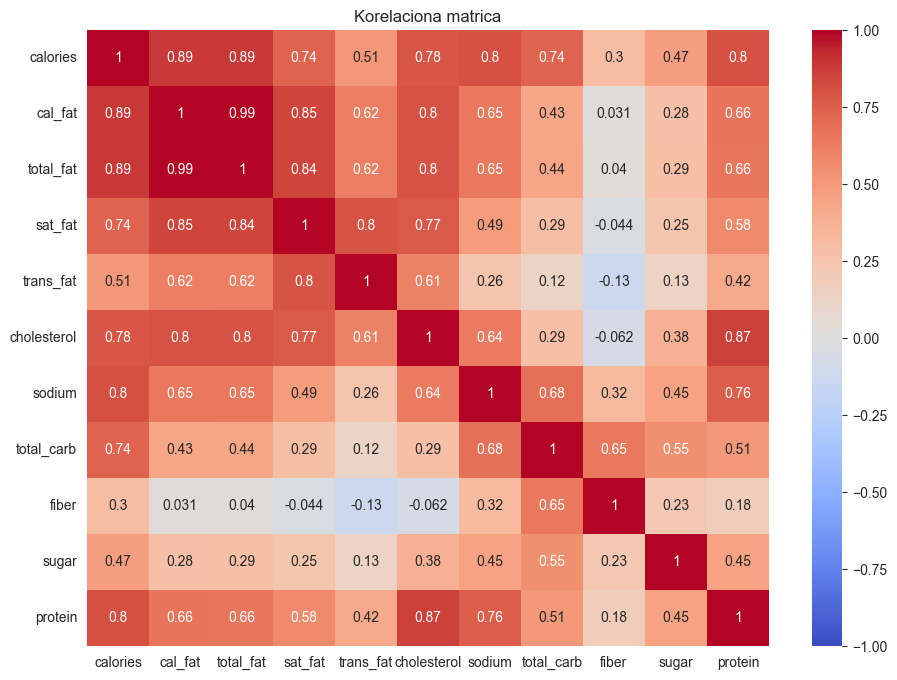

    total_fat  protein
0           7     37.0
1          45     46.0
2          67     70.0
3          31     55.0
4          45     46.0
5          28     25.0
6          12     15.0
7          24     25.0
8          21     25.0
9          45     51.0
10         18     15.0
11         34     32.0
12         20     42.0
13         34     33.0
14          8     13.0
15          5     24.0
16         36     37.0
17         21     48.0
18         35     39.0
19         15     15.0


In [25]:
# Prikaz matrice korelacije
corr = data_numeric.corr(numeric_only=True).round(4)
plt.figure(figsize=(11,8))
sb.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Korelaciona matrica')
plt.show()
print(data_numeric[['total_fat', 'protein']].head(20))

In [26]:
# 4) Izbor prediktora
target = 'protein'
features = ['cholesterol', 'calories', 'sodium']
#Na korelacionoj matrici se može primetiti da su za predviđaje atributa protein najznačajni(najveća korelisanost) atributi:
#   1)cholesterol - 0.87 (jedinično povećanje atributa cholesterol dovešće do povećanja atributa protein za 0.87)
#   2)calories - 0.8 (jedinično povećanje atributa calories dovešće do povećanja atributa protein za 0.8)
#   3)sodium - 0.76 (jedinično povećanje atributa sodium dovešće do povećanja atributa protein za 0.76)

In [27]:
# 5) Podela na train i test
train_df, test_df = train_test_split(data_subset, test_size=0.2, random_state=123)
# Provera train i test
print(f"Broj redova u train skupu: {len(train_df)}")
print(f"Broj redova u test skupu: {len(test_df)}")

Broj redova u train skupu: 410
Broj redova u test skupu: 103


In [28]:
# 6) Pravljenje modela
lm1 = smf.ols(f'{target} ~ ' + ' + '.join(features), data=train_df).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                protein   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     778.0
Date:                Wed, 24 Sep 2025   Prob (F-statistic):          1.17e-167
Time:                        14:40:29   Log-Likelihood:                -1326.2
No. Observations:                 409   AIC:                             2660.
Df Residuals:                     405   BIC:                             2677.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.5108      0.694      3.618      

In [29]:
#Reziduali predstavljaju razliku između stvarnih i predviđenih vrednosti ciljne promenljive (protein).
#Idealno je da su ravnomerno raspodeljeni oko nule.
#Medijana reziduala je -0.702, što znači da je polovina grešaka manja, a polovina veća od te vrednosti.
#Intercept (presretanje) iznosi 2.5108, sto znaci da kada su sve nezavisne promenljive jednake nuli, očekivana vrednost proteina je oko 2.51.
#Koeficijenti:
# - cholesterol: koeficijent 0.1970 → povećanje za 1 jedinicu dovodi do rasta proteina za ~0.197.
# - calories:    koeficijent 0.0057 → povećanje za 1 jedinicu dovodi do rasta proteina za ~0.0057.
# - sodium:      koeficijent 0.0066 → povećanje za 1 jedinicu dovodi do rasta proteina za ~0.0066.
#Statistička značajnost:
# - cholesterol i sodium imaju p-vrednosti < 0.001 → vrlo značajni prediktori.
# - calories ima p = 0.015 → takođe je statistički značajan (p < 0.05).
#R-kvadrat iznosi 0.852 → model objašnjava oko 85.2% varijabilnosti ciljne promenljive.
#F-statistika je visoka (778.0), a p-vrednost skoro nula → model kao celina je značajan.
#Upozorenje: Condition number je 3.45e+03 → može postojati multikolinearnost.
#Dodatna provera putem VIF vrednosti je neophodna.

In [30]:
#Predikcija na test skupu
y_true = test_df['protein']
X_test = test_df[['cholesterol', 'calories', 'sodium']]
y_pred = lm1.predict(X_test)

results = pd.DataFrame({
    'Stvarno': y_true.values,
    'Predviđeno': y_pred.round(2)
})
#Prikaz prvih 10 predikcija
print(results.head(10))

     Stvarno  Predviđeno
34      28.0       24.40
202     22.0       21.78
86      15.0       15.56
276     13.0       17.99
36      58.0       47.86
5       25.0       27.61
287     17.0       18.84
402     16.0       16.54
439     13.0       13.48
437      8.0       10.32


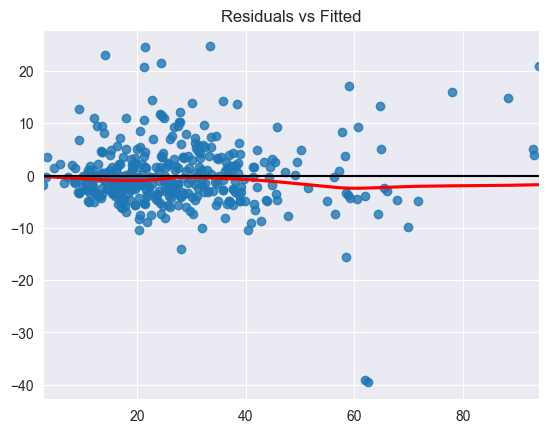

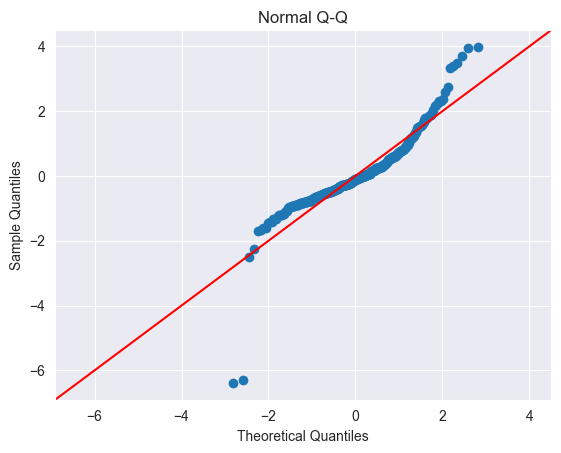

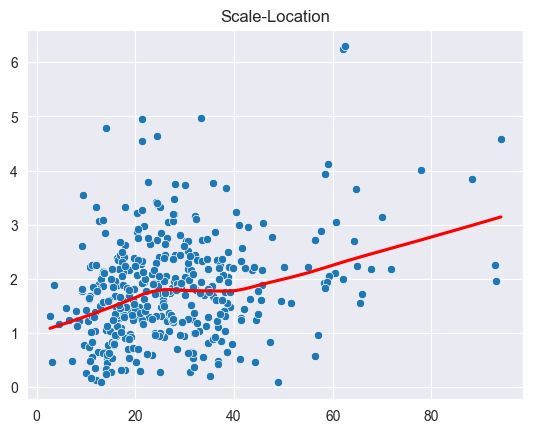

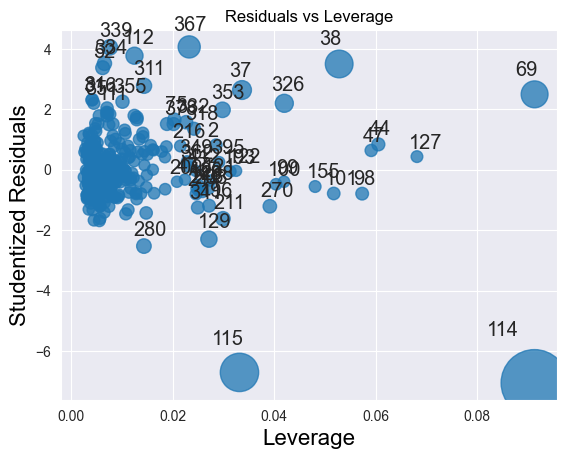

In [31]:
# 8) Dijagnostički grafikoni
sb.residplot(x=lm1.fittedvalues, y=lm1.resid, lowess=True, line_kws={'color':'red'})
plt.axhline(0, color='black'); plt.title('Residuals vs Fitted'); plt.show()
sm.qqplot(lm1.resid, fit=True, line='45'); plt.title('Normal Q-Q'); plt.show()
sqrt_abs_resid = np.sqrt(np.abs(lm1.resid))
sb.scatterplot(x=lm1.fittedvalues, y=sqrt_abs_resid)
sb.regplot(x=lm1.fittedvalues, y=sqrt_abs_resid, scatter=False, lowess=True, line_kws={'color':'red'})
plt.title('Scale-Location'); plt.show()
sm.graphics.influence_plot(lm1, criterion='cooks'); plt.title('Residuals vs Leverage'); plt.show()

In [32]:
# - Residuals vs Fitted -
# Grafikon prikazuje raspodelu reziduala (razlike između stvarnih i predviđenih vrednosti) u odnosu na predviđene vrednosti.
# Ovaj grafikon se koristi da proveri da li je zadovoljena pretpostavka linearne veze.
# Residuali bi trebalo da budu raspoređeni oko horizontalne linije (vrednost bliska nuli).
# Sa grafikona se može zaključiti da postoje manja odstupanja (nelineranost), što može ukazivati na neadekvatnost modela.
# - Normal Q-Q -
# Ovaj grafikon prikazuje da li reziduali imaju normalnu raspodelu.
# Tačke bi trebalo da leže duž dijagonale.
# Pošto tačke odstupaju od dijagonale na krajevima, pretpostavka normalnosti nije u potpunosti ispunjena.
# - Scale-Location -
# Prikazuje da li je varijabilnost (varijansa) reziduala konstantna duž predikcija.
# Idealno, crvena linija treba da bude horizontalna i da tačke budu ravnomerno raspoređene.
# U ovom slučaju, varijansa reziduala nije potpuno konstantna, što ukazuje na moguću heteroskedastičnost.
# - Residuals vs Leverage -
# Ovaj grafikon identifikuje ekstremno visoke/niske vrednosti (outliere) i njihove uticaje na model.
# Većina tačaka bi trebalo da bude unutar granica, a ekstremne vrednosti retke.
# Na osnovu Cookove distance vidi se da postoji nekoliko potencijalnih outliera, što može uticati na stabilnost modela.

In [33]:
#Provera multikolinearnosti
X = sm.add_constant(train_df[features])
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
print('√VIF prve verzije:\n', np.sqrt(vif))
#S obzirom da je za atribut calories sqrt(vif) vrednost >2, može se zaključiti da postoji multikorelisanost, koja može dovesti do nepouzdanih procena.
#Novi model za predikciju proteina treba kreirati sa atributima cholesterol i sodium.
lm2 = smf.ols(f'{target} ~ cholesterol + sodium', data=train_df).fit()
#Provera VIF za novi model
X = sm.add_constant(train_df[['cholesterol', 'sodium']])
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
print('√VIF druge verzije:\n', np.sqrt(vif))
#Multikolinearnost ne postoji više.

√VIF prve verzije:
 const          2.255865
cholesterol    1.623138
calories       2.069238
sodium         1.673344
dtype: float64
√VIF druge verzije:
 const          2.097196
cholesterol    1.311350
sodium         1.311350
dtype: float64
